## Projeto: Fast Invest

Grupo: Eric Marques e Kalolayna

## Objeto de pesquisa

Mercado de ações.

## Problema de pesquisa

É possível encontrar padrões no comportamento do investidor e na valorização e desvalorização de uma ação?

## Objetivos

- Identificar as variáveis que são importantes e de que maneira elas se influenciam.
- Identificar padrões para a decisão do investidor de comprar e vender uma ação.
- Correlacionar variáveis externas ao mercado de ações com o desempenho da ação nos pregões.
- Criar um modelo de recomendação para investimento.
- Deploy utilizando Streamlit

## Fonte dos dados

- API do Yahoo Finance para obter informações das ações e do Ibovespa.
- API do Banco central para obter informações sobre a SELIC.

In [5]:
import yfinance as yf
import locale
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from deep_translator import GoogleTranslator

### Tradutor para info das empresas

In [2]:
# Configura o locale para o Brasil para formatação de números
tradutor = GoogleTranslator(source="en", target="pt")

### Configurando o local para tratamento de valores $

In [3]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

### Coleta de dados individuais ou coletivos (Sistema em construção) - Seguir para a análise de ação (individual)

Baixar lista básica para testes ou não usar a opção 3 para ler arquivo CSV.

Site: https://www.dadosdemercado.com.br/bolsa/acoes

In [6]:
# Carrega a lista de tickers de ações da B3 a partir de um arquivo CSV
lista_tickers = pd.read_csv('acoes-listadas-b3.csv')

In [7]:
lista_tickers

,Ticker,Nome,Negócios,Última (R$),Variação
0,MGLU3,Magazine Luiza,103.812.100,"1,80","-1,10%"
1,HAPV3,Hapvida,86.236.900,"3,70","-1,60%"
2,AMER3,Americanas,68.690.700,"0,65","+18,18%"
3,CVCB3,CVC,55.317.100,"2,90","-4,29%"
4,ABEV3,Ambev,44.403.500,"12,49","+0,32%"
...,...,...,...,...,...
530,TKNO3,Tekno,100,"85,79","+10,64%"
531,COCE6,Coelce,100,"35,00","+16,63%"
532,MGEL3,Mangels,100,"75,00","+8,70%"
533,CTSA8,Santanense,2.000,"1,00","+0,00%"


In [8]:
# Adiciona a extensão ".SA" aos tickers para torná-los compatíveis com o Yahoo Finance
lista_tickers["Ticker"] = lista_tickers["Ticker"] + ".SA"
print(lista_tickers.head())

     Ticker            Nome     Negócios Última (R$) Variação
0  MGLU3.SA  Magazine Luiza  103.812.100        1,80   -1,10%
1  HAPV3.SA         Hapvida   86.236.900        3,70   -1,60%
2  AMER3.SA      Americanas   68.690.700        0,65  +18,18%
3  CVCB3.SA             CVC   55.317.100        2,90   -4,29%
4  ABEV3.SA           Ambev   44.403.500       12,49   +0,32%


In [9]:
# Função para obter os tickers de ações
def obter_tickers():

    while True:
        print("Escolha uma opção para obter os tickers:")
        print("1. Digitar um ticker específico.")
        print("2. Digitar um conjunto de tickers manualmente.")
        print("3. Ler os tickers de um arquivo CSV.")
        print()

        opcao = int(input('''Escolha uma opção para obter os tickers:
        1. Digitar um ticker específico.
        2. Digitar um conjunto de tickers manualmente.
        3. Ler os tickers de um arquivo CSV.'''))

        if opcao == 1:
            ticker_especifico = input("Digite o ticker específico: ").upper()
            return [ticker_especifico]
        elif opcao == 2:
            tickers_manual = input("Digite os tickers separados por vírgula: ").upper()
            return tickers_manual.split(",")
        elif opcao == 3:
            arquivo_csv = input("Digite o nome do arquivo CSV: ")
            try:
                tickers_df = pd.read_csv(arquivo_csv)
                return tickers_df["Ticker"].tolist()
            except FileNotFoundError:
                print("Arquivo CSV não encontrado.")
                continue
        else:
            print("Opção inválida.")
            continue

In [10]:
# Função para obter o período de análise
def obter_periodo():

    while True:
        print("Escolha uma opção para o período de análise:")
        print("1. Digitar um período personalizado de início e fim.")
        print("2. Receber os dados de todo o período até a data atual.")
        print()

        opcao = int(input('''Escolha uma opção para o período de análise:
        1. Digitar um período personalizado de início e fim.
        2. Receber os dados de todo o período até a data atual.'''))

        if opcao == 1:
            data_inicio = input("Digite a data de início (no formato YYYY-MM-DD): ")
            data_fim = input("Digite a data de fim (no formato YYYY-MM-DD): ")
            if data_inicio and data_fim:
                return data_inicio, data_fim
            else:
                print("Período inválido.")
                continue
        elif opcao == 2:
            return "1900-01-01", pd.Timestamp.now().strftime("%Y-%m-%d")
        else:
            print("Opção inválida.")
            continue

In [11]:
# Função para baixar e concatenar os dados de ações
def concatenar_dados_tickers(tickers, periodo_inicio, periodo_fim):

    dados_conjunto_tickers = []

    for ticker in tickers:
        dados_ticker = yf.download(ticker, start=periodo_inicio, end=periodo_fim)
        dados_ticker['Ticker'] = ticker  
        dados_conjunto_tickers.append(dados_ticker)

    dados_concatenados = pd.concat(dados_conjunto_tickers)

    return dados_concatenados

In [12]:
# Função principal para obter dados de ações
def obter_dados_acao():

    tickers = obter_tickers()
    if not tickers:
        print("Nenhum ticker selecionado.")
        return None

    data_inicio, data_fim = obter_periodo()
    if not data_inicio or not data_fim:
        print("Período inválido.")
        return None

    for ticker in tickers:
        dados = yf.download(ticker, start=data_inicio, end=data_fim)
        try:
            dados.to_csv(f'dados-{ticker}.csv')
            print(f"Dados da ação {ticker} salvos com sucesso em 'dados-{ticker}.csv'")
        except Exception as e:
            print(f"Não foi possível salvar os dados da ação {ticker}: {e}")

    return dados

Iniciando a obtenção dos dados para análise

In [13]:
# Obtém os dados das ações
dados_acao = obter_dados_acao()

Escolha uma opção para obter os tickers:
1. Digitar um ticker específico.
2. Digitar um conjunto de tickers manualmente.
3. Ler os tickers de um arquivo CSV.

Escolha uma opção para o período de análise:
1. Digitar um período personalizado de início e fim.
2. Receber os dados de todo o período até a data atual.



[*********************100%%**********************]  1 of 1 completed


Dados da ação PETR4.SA salvos com sucesso em 'dados-PETR4.SA.csv'


In [14]:
# Exibe os dados das ações
dados_acao

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,5.875000,5.875000,5.875000,5.875000,1.443121,35389440000
2000-01-04,5.550000,5.550000,5.550000,5.550000,1.363289,28861440000
2000-01-05,5.494000,5.494000,5.494000,5.494000,1.349534,43033600000
2000-01-06,5.475000,5.475000,5.475000,5.475000,1.344867,34055680000
2000-01-07,5.500000,5.500000,5.500000,5.500000,1.351007,20912640000
...,...,...,...,...,...,...
2024-05-20,36.730000,37.240002,36.630001,36.750000,36.750000,40400400
2024-05-21,36.790001,37.090000,36.570000,36.680000,36.680000,27967400
2024-05-22,36.500000,37.459999,36.410000,37.180000,37.180000,36528800


### Análise de ação (individual)

In [15]:
# Obtém a data atual no formato 'YYYY-MM-DD'
data_atual = datetime.datetime.now().strftime('%Y-%m-%d')

In [16]:
# Obtém a data atual no formato 'DD-MM-YY'
data_atual2 = datetime.datetime.now().strftime('%d-%m-%y')

In [17]:
# Define o ticker, data iniício da análise e data de fim 
ticker = 'PETR4.SA'
inicio = '2019-4-8'
fim = data_atual

In [18]:
# Cria um objeto da classe Ticker para a empresa com o ticker especificado
empresa = yf.Ticker(ticker)
info_empresa = empresa.info

In [19]:
# Função para obter os dados da ação da Petrobras no período especificado
def obter_acao_individual(ticker, inicio, fim):
    dados = yf.download(ticker, start=inicio, end=fim)
    return dados

In [20]:
# Obtém os dados da ação da Petrobras no período especificado
dados_acao = obter_acao_individual(ticker, inicio, fim)

[*********************100%%**********************]  1 of 1 completed


In [21]:
# Exibe os dados da ação
dados_acao

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-08,29.059999,29.389999,28.980000,29.250000,10.365389,55270000
2019-04-09,29.030001,29.240000,28.670000,29.160000,10.333495,43863700
2019-04-10,29.549999,29.570000,28.780001,28.780001,10.198833,62005200
2019-04-11,28.700001,28.700001,27.870001,28.000000,9.922425,56126400
2019-04-12,26.469999,26.969999,25.570000,25.830000,9.153437,227307600
...,...,...,...,...,...,...
2024-05-20,36.730000,37.240002,36.630001,36.750000,36.750000,40400400
2024-05-21,36.790001,37.090000,36.570000,36.680000,36.680000,27967400
2024-05-22,36.500000,37.459999,36.410000,37.180000,37.180000,36528800


In [27]:
# Exibe as primeiras linhas dos dados
dados_acao.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-08,29.059999,29.389999,28.980000,29.250000,10.365389,55270000
2019-04-09,29.030001,29.240000,28.670000,29.160000,10.333495,43863700
2019-04-10,29.549999,29.570000,28.780001,28.780001,10.198833,62005200
2019-04-11,28.700001,28.700001,27.870001,28.000000,9.922425,56126400
2019-04-12,26.469999,26.969999,25.570000,25.830000,9.153437,227307600


In [28]:
# Descreve estatísticas dos dados
dados_acao.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1.276000e+03
mean,28.340972,28.758605,27.919099,28.341450,16.144195,6.772180e+07
std,5.465577,5.490828,5.470404,5.492614,9.143851,3.721073e+07
min,11.070000,12.180000,10.850000,11.290000,4.133756,1.282670e+07
25%,25.157500,25.697501,24.704999,25.262500,9.608704,4.408492e+07
50%,28.000000,28.375000,27.605000,28.010000,11.420920,5.856250e+07
75%,31.327500,31.897500,30.809999,31.442501,19.898560,8.180522e+07
max,42.770000,42.939999,42.560001,42.900002,41.669998,4.902304e+08


In [29]:
dados_acao.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1276.0,2.834097e+01,5.465577e+00,1.107000e+01,2.515750e+01,2.800000e+01,3.132750e+01,4.277000e+01
High,1276.0,2.875861e+01,5.490828e+00,1.218000e+01,2.569750e+01,2.837500e+01,3.189750e+01,4.294000e+01
Low,1276.0,2.791910e+01,5.470404e+00,1.085000e+01,2.470500e+01,2.760500e+01,3.081000e+01,4.256000e+01
Close,1276.0,2.834145e+01,5.492614e+00,1.129000e+01,2.526250e+01,2.801000e+01,3.144250e+01,4.290000e+01
Adj Close,1276.0,1.614419e+01,9.143851e+00,4.133756e+00,9.608704e+00,1.142092e+01,1.989856e+01,4.167000e+01
Volume,1276.0,6.772180e+07,3.721073e+07,1.282670e+07,4.408492e+07,5.856250e+07,8.180522e+07,4.902304e+08


In [30]:
# Obtém o formato dos dados
dados_acao.shape

(1276, 6)

In [31]:
# Obtém os tipos de dados
dados_acao.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [32]:
# Obtém o número de valores não nulos em cada coluna
dados_acao.count()

Open         1276
High         1276
Low          1276
Close        1276
Adj Close    1276
Volume       1276
dtype: int64

In [33]:
# Obtém informações sobre os dados, incluindo tipos de dados e valores não nulos
dados_acao.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1276 entries, 2019-04-08 to 2024-05-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1276 non-null   float64
 1   High       1276 non-null   float64
 2   Low        1276 non-null   float64
 3   Close      1276 non-null   float64
 4   Adj Close  1276 non-null   float64
 5   Volume     1276 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 69.8 KB


### Fechamento da ação

In [34]:
# Função para analisar o preço de fechamento da ação
def analisar_acao_close(dados):
    dados['MM60'] = dados['Close'].rolling(window=60).mean()
    dados['MM180'] = dados['Close'].rolling(window=180).mean()
    plt.figure(figsize=(12, 6))
    plt.plot(dados['Close'], label='Preço de Fechamento')
    plt.plot(dados['MM60'], label='Média Móvel de 60 dias')
    plt.plot(dados['MM180'], label='Média Móvel de 180 dias')
    plt.title(f'Análise do Preço de Fechamento da Ação {ticker} até {data_atual}')
    plt.xlabel('Data')
    plt.ylabel('Preço')
    plt.legend()
    plt.show()

In [35]:
# Obtém algumas estatísticas adicionais do preço de fechamento
media_preco = dados_acao['Close'].mean()
mediana_preco = dados_acao['Close'].median()
min_preco = dados_acao['Close'].min()
max_preco = dados_acao['Close'].max()
std_preco = dados_acao['Close'].std()

In [36]:
# Formata os valores para exibição
valor_atual_tratado = locale.currency(dados_acao['Close'].iloc[-1], grouping=True)
media_preco_tratada = locale.currency(media_preco, grouping=True)
mediana_preco_tratada = locale.currency(mediana_preco, grouping=True)
min_preco_tratado = locale.currency(min_preco, grouping=True)
max_preco_tratado = locale.currency(max_preco, grouping=True)
std_preco_tratado = locale.currency(std_preco, grouping=True)

In [37]:
type(valor_atual_tratado) # Inútil para manipulação

str

In [38]:
# Obtém a descrição da empresa
texto_original = info_empresa['longBusinessSummary']
texto_traduzido = tradutor.translate(texto_original)
print("Texto traduzido:", texto_traduzido)


Texto traduzido: Petróleo Brasileiro S.A. - A Petrobras explora, produz e comercializa petróleo e gás no Brasil e internacionalmente. A empresa atua por meio de três segmentos: Exploração e Produção; Refino, Transporte e Comercialização; e Gás e Energia. O segmento de Exploração e Produção explora, desenvolve e produz petróleo bruto, líquidos de gás natural e gás natural principalmente para abastecimento às refinarias nacionais. O segmento de Refino, Transporte e Comercialização atua no refino, logística, transporte, aquisição e exportação de petróleo bruto; e produção de fertilizantes, além de participação em empresas petroquímicas. O segmento de Gás e Energia atua na logística e comercialização de gás natural e eletricidade; transporte e comercialização de GNL; geração de energia elétrica por meio de usinas termelétricas; negócios de energia renovável; serviços de baixo carbono; e negócios de processamento de gás natural, bem como produção de biodiesel e seus coprodutos. A empresa ta

Nome da empresa: Petróleo Brasileiro S.A. - Petrobras
Ticker da ação: PETR4.SA
Setor: Energy

Descrição:
Petróleo Brasileiro S.A. - A Petrobras explora, produz e comercializa petróleo e gás no Brasil e int
ernacionalmente. A empresa atua por meio de três segmentos: Exploração e Produção; Refino, Transport
e e Comercialização; e Gás e Energia. O segmento de Exploração e Produção explora, desenvolve e prod
uz petróleo bruto, líquidos de gás natural e gás natural principalmente para abastecimento às refina
rias nacionais. O segmento de Refino, Transporte e Comercialização atua no refino, logística, transp
orte, aquisição e exportação de petróleo bruto; e produção de fertilizantes, além de participação em
 empresas petroquímicas. O segmento de Gás e Energia atua na logística e comercialização de gás natu
ral e eletricidade; transporte e comercialização de GNL; geração de energia elétrica por meio de usi
nas termelétricas; negócios de energia renovável; serviços de baixo carbono; e negócios

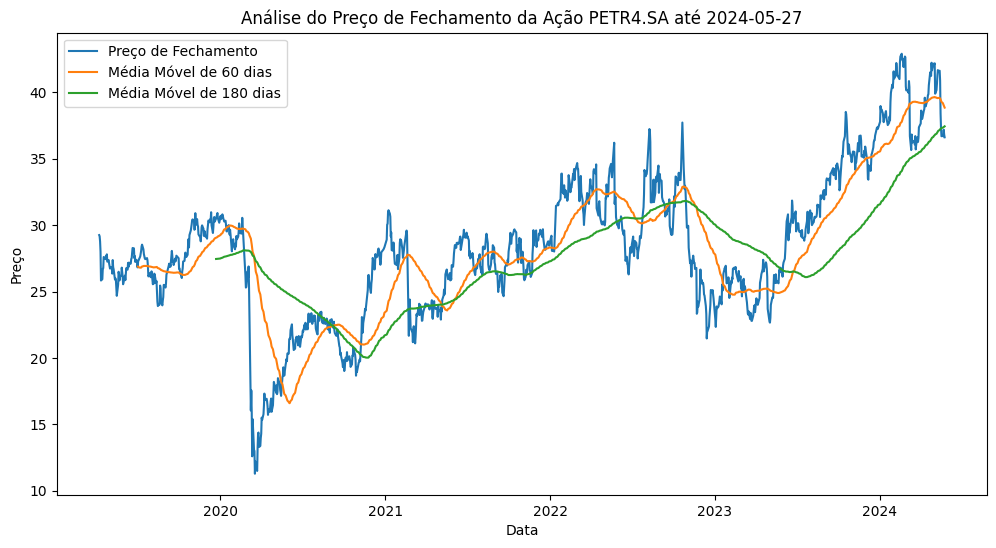

In [39]:
# Imprime a descrição da empresa
print("Nome da empresa:", info_empresa['longName'])
print("Ticker da ação:", ticker)
print("Setor:", info_empresa['sector'])
print()
print("Descrição:")
tamanho_parte = 100
for i in range(0, len(texto_traduzido), tamanho_parte):
    parte_descricao = texto_traduzido[i:i + tamanho_parte]
    print(parte_descricao)
print()
print("Valor atual da ação:", valor_atual_tratado)
print("Média do Preço de Fechamento:", media_preco_tratada)
print("Mediana do Preço de Fechamento:", mediana_preco_tratada)
print("Mínimo do Preço de Fechamento:", min_preco_tratado)
print("Máximo do Preço de Fechamento:", max_preco_tratado)
print("Desvio Padrão do Preço de Fechamento:", std_preco_tratado)

analisar_acao_close(dados_acao)

In [40]:
# Cria um DataFrame com os dados de fechamento da ação
fechamento = dados_acao['Close']
fechamento

Date
2019-04-08    29.250000
2019-04-09    29.160000
2019-04-10    28.780001
2019-04-11    28.000000
2019-04-12    25.830000
                ...    
2024-05-20    36.750000
2024-05-21    36.680000
2024-05-22    37.180000
2024-05-23    36.810001
2024-05-24    36.610001
Name: Close, Length: 1276, dtype: float64

In [41]:
df_fechamento = pd.DataFrame(fechamento)
df_fechamento

,Close
Date,
2019-04-08,29.250000
2019-04-09,29.160000
2019-04-10,28.780001
2019-04-11,28.000000
2019-04-12,25.830000
...,...
2024-05-20,36.750000
2024-05-21,36.680000
2024-05-22,37.180000


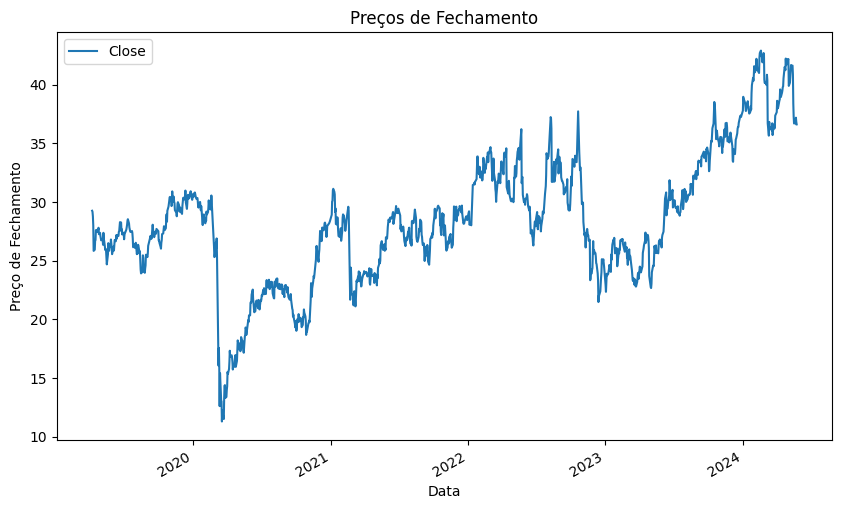

In [42]:
# Plota um histograma dos preços de fechamento
df_fechamento.plot(figsize=(10, 6))
plt.title('Preços de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.show()

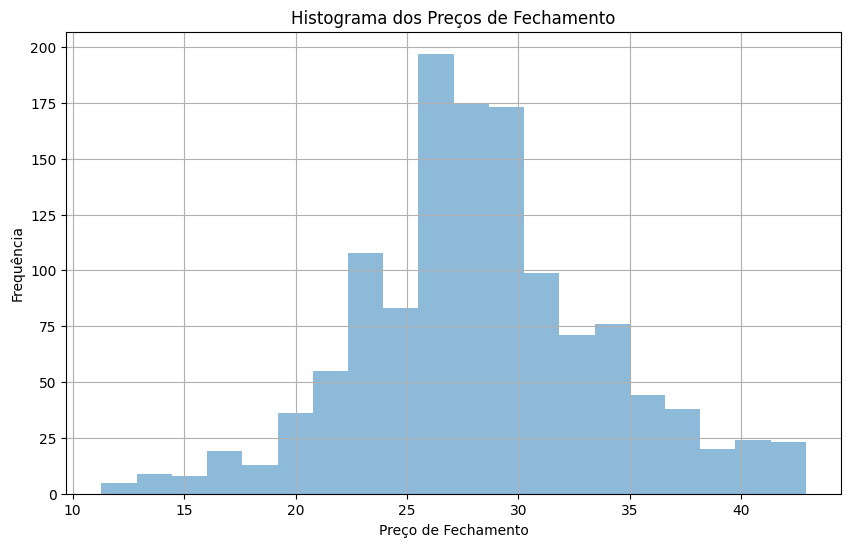

In [43]:
# Obtém os dados da ação da Petrobras para os últimos 5 anos
df_fechamento.hist(bins=20, alpha=0.5, figsize=(10, 6))
plt.title('Histograma dos Preços de Fechamento')
plt.xlabel('Preço de Fechamento')
plt.ylabel('Frequência')
plt.show()

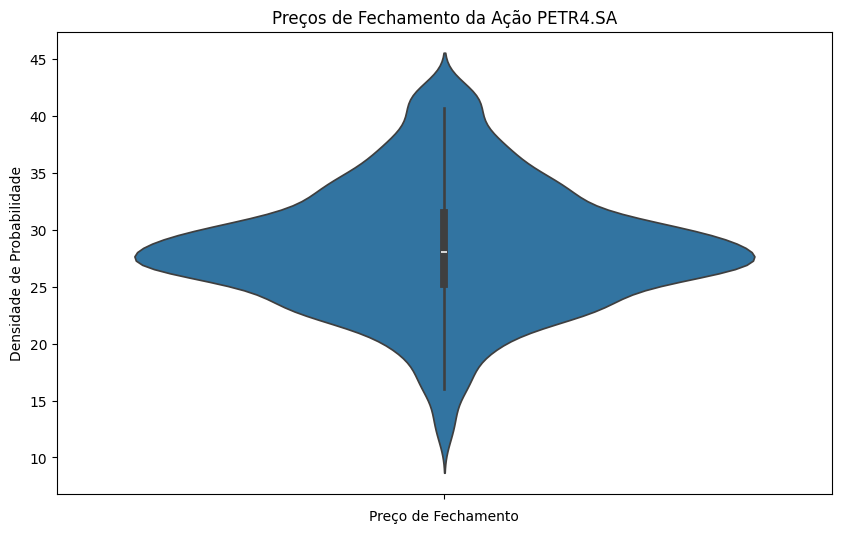

In [44]:
# Plota um gráfico de violino dos preços de fechamento
plt.figure(figsize=(10, 6))
sns.violinplot(data=dados_acao['Close'])
plt.title('Preços de Fechamento da Ação PETR4.SA')
plt.xlabel('Preço de Fechamento')
plt.ylabel('Densidade de Probabilidade')
plt.show()

In [45]:
# Obtém os dados da ação da Petrobras para os últimos 5 anos
petr4_data = yf.download("PETR4.SA", start="2019-04-08", end=data_atual)
petr4_data['Year'] = petr4_data.index.year

[*********************100%%**********************]  1 of 1 completed


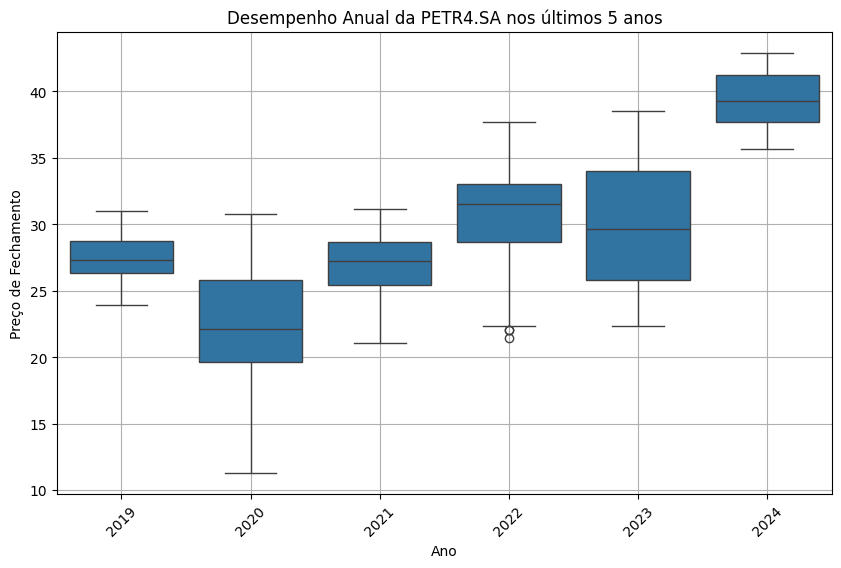

In [46]:
# Plota um boxplot do desempenho anual da ação nos últimos 5 anos
plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='Close', data=petr4_data)
plt.title('Desempenho Anual da PETR4.SA nos últimos 5 anos')
plt.xlabel('Ano')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Presença de outliers. Apesar de serem poucos. É importante verificar.

In [47]:
df_dados_acao = pd.DataFrame(dados_acao['Close'])
df_dados_acao

,Close
Date,
2019-04-08,29.250000
2019-04-09,29.160000
2019-04-10,28.780001
2019-04-11,28.000000
2019-04-12,25.830000
...,...
2024-05-20,36.750000
2024-05-21,36.680000
2024-05-22,37.180000


In [48]:
# Calcula os outliers
q1 = df_dados_acao['Close'].quantile(0.25)
q3 = df_dados_acao['Close'].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr
outliers = df_fechamento[(df_fechamento['Close'] < limite_inferior) | (df_fechamento['Close'] > limite_superior)]
outliers_count = outliers.shape[0]

In [49]:
# Exibe informações sobre 
print("Primeiro Quartil (Q1):", q1)
print("Terceiro Quartil (Q3):", q3)
print("Amplitude Interquartil (IQR):", iqr)
print("Mediana do Preço de Fechamento:", mediana_preco)
print("Número de outliers:", outliers_count)
print("Limite inferior para outliers:", limite_inferior)
print("Limite superior para outliers:", limite_superior)

Primeiro Quartil (Q1): 25.262500286102295
Terceiro Quartil (Q3): 31.442500591278076
Amplitude Interquartil (IQR): 6.180000305175781
Mediana do Preço de Fechamento: 28.010000228881836
Número de outliers: 54
Limite inferior para outliers: 15.992499828338623
Limite superior para outliers: 40.71250104904175


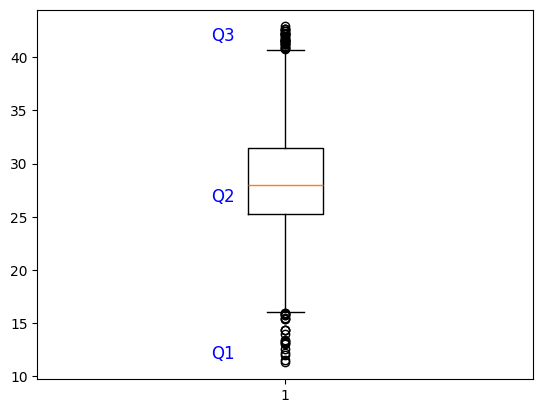

In [50]:
# Plota um boxplot com destaque para os outliers
plt.boxplot(dados_acao['Close'])
plt.text(0.85, min(dados_acao['Close']), 'Q1', color='blue', fontsize=12, verticalalignment='bottom')
plt.text(0.85, max(dados_acao['Close']), 'Q3', color='blue', fontsize=12, verticalalignment='top')
plt.text(0.85, dados_acao['Close'].iloc[len(dados_acao['Close'])//2], 'Q2', color='blue', fontsize=12, verticalalignment='center')
plt.show()

- 25% dos valores são menores ou iguais a Q1
- 75% dos valores são menores ou iguais a Q3
- Distância entre o Q1 e Q3: 5.76

In [54]:
# Exibe os outliers
outliers.head(10)

,Close
Date,
2020-03-11,15.85
2020-03-12,12.60
2020-03-13,15.40
2020-03-16,13.09
2020-03-17,13.00
2020-03-18,11.29
2020-03-19,12.21
2020-03-20,12.00
2020-03-23,11.50


In [55]:
# Obtém os dados de volume da ação
volume = dados_acao['Volume']
volume

Date
2019-04-08     55270000
2019-04-09     43863700
2019-04-10     62005200
2019-04-11     56126400
2019-04-12    227307600
                ...    
2024-05-20     40400400
2024-05-21     27967400
2024-05-22     36528800
2024-05-23     47987800
2024-05-24     23684700
Name: Volume, Length: 1276, dtype: int64

#### Formatação do volume de negociação para facilitar a leitura

In [57]:
# Formata o volume para exibição
volume_tratado = volume.apply(lambda x: '{:,.0f}'.format(x)).str.replace(',', '.')
volume_tratado

Date
2019-04-08     55.270.000
2019-04-09     43.863.700
2019-04-10     62.005.200
2019-04-11     56.126.400
2019-04-12    227.307.600
                 ...     
2024-05-20     40.400.400
2024-05-21     27.967.400
2024-05-22     36.528.800
2024-05-23     47.987.800
2024-05-24     23.684.700
Name: Volume, Length: 1276, dtype: object

In [58]:
# Função para analisar o volume de negociação da ação
def analisar_acao_volume(dados):
    dados['MM60'] = dados['Volume'].rolling(window=60).mean()
    dados['MM180'] = dados['Volume'].rolling(window=180).mean()
    plt.figure(figsize=(12, 6))
    plt.plot(dados['Volume'], label='Volume de negociação')
    plt.plot(dados['MM60'], label='Média Móvel de 60 dias')
    plt.plot(dados['MM180'], label='Média Móvel de 180 dias')
    plt.title(f'Análise do volume de negociação da Ação {ticker} até {data_atual}')
    plt.xlabel('Data')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()

In [59]:
# Calcula estatísticas sobre o volume de negociação
media_volume = dados_acao['Volume'].mean()
mediana_volume = dados_acao['Volume'].median()
min_volume = dados_acao['Volume'].min()
max_volume = dados_acao['Volume'].max()
std_volume = dados_acao['Volume'].std()

#### Tratamento apenas para impressão.

In [60]:
# Formatação dos valores de volume para exibição
volume_atual_tratado = '{:,.0f}'.format(dados_acao['Volume'].iloc[-1]).replace(',', '.')
media_volume_tratada = '{:,.0f}'.format(media_volume).replace(',', '.')
mediana_volume_tratada = '{:,.0f}'.format(mediana_volume).replace(',', '.')
min_volume_tratada = '{:,.0f}'.format(min_volume).replace(',', '.')
max_volume_tratada = '{:,.0f}'.format(max_volume).replace(',', '.')
std_volume_tratada = '{:,.0f}'.format(std_volume).replace(',', '.')

In [61]:
# Exibição das estatísticas do volume de negociação
print("Volume atual da ação:", volume_atual_tratado)
print("Média do Volume:", media_volume_tratada)
print("Mediana do Volume:", mediana_volume_tratada)
print("Mínimo do Volume:", min_volume_tratada)
print("Máximo do Volume:", max_volume_tratada)
print("Desvio Padrão do Volume:", std_volume_tratada)

Volume atual da ação: 23.684.700
Média do Volume: 67.721.801
Mediana do Volume: 58.562.500
Mínimo do Volume: 12.826.700
Máximo do Volume: 490.230.400
Desvio Padrão do Volume: 37.210.726


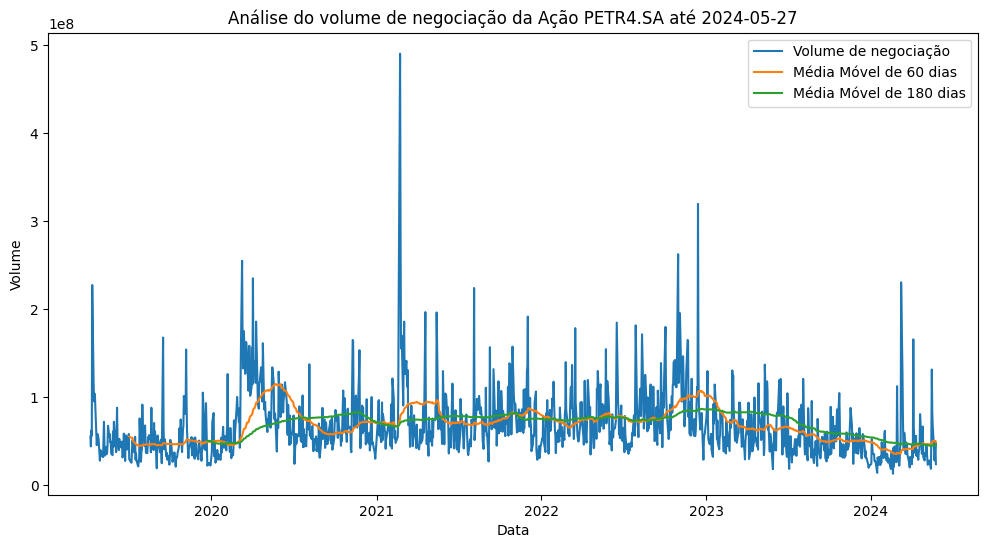

In [62]:
# Chamada da função para analisar o volume de negociação
analisar_acao_volume(dados_acao)

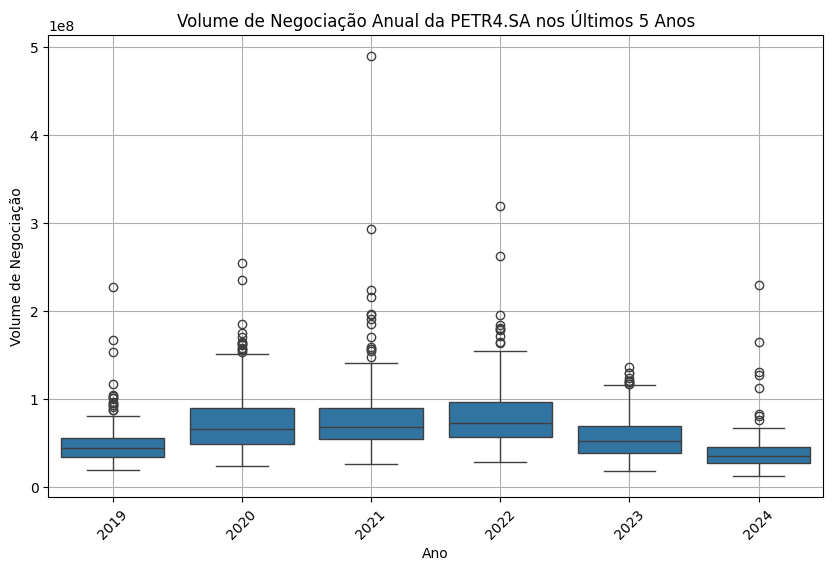

In [63]:
# Gráfico de boxplot do volume de negociação anual
plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='Volume', data=petr4_data)
plt.title('Volume de Negociação Anual da PETR4.SA nos Últimos 5 Anos')
plt.xlabel('Ano')
plt.ylabel('Volume de Negociação')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Presença de outliers no volume de negociação. Investigar a importância deles correlacionando com outras variáveis que possam explicá-los.

In [64]:
# Cálculo e exibição de estatísticas sobre o volume de negociação
q1_volume = dados_acao['Volume'].quantile(0.25)
q3_volume = dados_acao['Volume'].quantile(0.75)
iqr_volume = q3_volume - q1_volume
limite_inferior_volume = q1_volume - 1.5 * iqr_volume
limite_superior_volume = q3_volume + 1.5 * iqr_volume
outliers_volume = dados_acao[(dados_acao['Volume'] < limite_inferior) | (dados_acao['Volume'] > limite_superior)]
outliers_count_volume = outliers_volume.shape[0]

- 25% dos valores são menores ou iguais a Q1
- 75% dos valores são menores ou iguais a Q3
- Distância entre o Q1 e Q3: 37792525.0

In [65]:
menor_valor = dados_acao['Volume'].min()
maior_valor = dados_acao['Volume'].max()

print("Menor valor de volume:", menor_valor)
print("Maior valor de volume:", maior_valor)

Menor valor de volume: 12826700
Maior valor de volume: 490230400


In [66]:
print("Primeiro Quartil (Q1):", q1_volume)
print("Terceiro Quartil (Q3):", q3_volume)
print("Amplitude Interquartil (IQR):", iqr_volume)
print("Menor valor de volume:", menor_valor)
print("Maior valor de volume:", maior_valor)
print("Número de outliers:", outliers_count_volume)
print("Limite inferior para outliers:", limite_inferior_volume)
print("Limite superior para outliers:", limite_superior_volume)

Primeiro Quartil (Q1): 44084925.0
Terceiro Quartil (Q3): 81805225.0
Amplitude Interquartil (IQR): 37720300.0
Menor valor de volume: 12826700
Maior valor de volume: 490230400
Número de outliers: 1276
Limite inferior para outliers: -12495525.0
Limite superior para outliers: 138385675.0


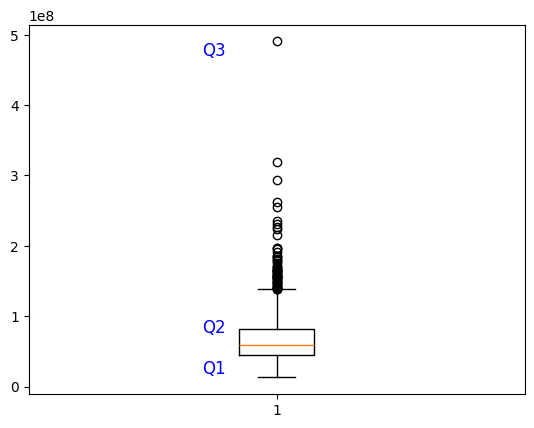

In [67]:
# Boxplot do volume de negociação com destaque para os quartis
plt.boxplot(dados_acao['Volume'])
plt.text(0.85, min(dados_acao['Volume']), 'Q1', color='blue', fontsize=12, verticalalignment='bottom')
plt.text(0.85, max(dados_acao['Volume']), 'Q3', color='blue', fontsize=12, verticalalignment='top')
plt.text(0.85, dados_acao['Volume'].iloc[len(dados_acao['Close'])//2], 'Q2', color='blue', fontsize=12, verticalalignment='center')
plt.show()

- É esperado que o volume de negociação tenha muitos outliers, pois todos os dias o número de negociações é completamente diferente, ou seja, é improvável que algum dia irá haver números iguais ou parecidos.

In [68]:
# Exibição dos outliers no volume de negociação
outliers.head(10)

,Close
Date,
2020-03-11,15.85
2020-03-12,12.60
2020-03-13,15.40
2020-03-16,13.09
2020-03-17,13.00
2020-03-18,11.29
2020-03-19,12.21
2020-03-20,12.00
2020-03-23,11.50


In [69]:
ticker_acao = "PETR4.SA"

In [70]:
# Cálculo da correlação entre volume de negociação e retorno da ação
dados_acao_adj_close = yf.download(ticker_acao, start=inicio, end=fim)["Adj Close"]
dados_acao_volume = yf.download(ticker_acao, start=inicio, end=fim)["Volume"]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [71]:
# Exibição dos dados de preços de fechamento ajustados da ação
dados_acao_adj_close

Date
2019-04-08    10.365389
2019-04-09    10.333495
2019-04-10    10.198833
2019-04-11     9.922425
2019-04-12     9.153437
                ...    
2024-05-20    36.750000
2024-05-21    36.680000
2024-05-22    37.180000
2024-05-23    36.810001
2024-05-24    36.610001
Name: Adj Close, Length: 1276, dtype: float64

In [72]:
# Exibição dos dados de volume de negociação da ação
dados_acao_volume

Date
2019-04-08     55270000
2019-04-09     43863700
2019-04-10     62005200
2019-04-11     56126400
2019-04-12    227307600
                ...    
2024-05-20     40400400
2024-05-21     27967400
2024-05-22     36528800
2024-05-23     47987800
2024-05-24     23684700
Name: Volume, Length: 1276, dtype: int64

In [73]:
# Cálculo do retorno percentual da ação com base nos preços de fechamento ajustados
retorno_acao2 = dados_acao_adj_close.pct_change()

In [74]:
# Exibição dos retornos da ação
retorno_acao2

Date
2019-04-08         NaN
2019-04-09   -0.003077
2019-04-10   -0.013032
2019-04-11   -0.027102
2019-04-12   -0.077500
                ...   
2024-05-20    0.001635
2024-05-21   -0.001905
2024-05-22    0.013631
2024-05-23   -0.009952
2024-05-24   -0.005433
Name: Adj Close, Length: 1276, dtype: float64

In [75]:
# Cálculo da correlação entre o volume de negociação e o retorno da ação
correlacao_volume_fechamento = dados_acao_volume.corr(retorno_acao2)
print("Correlação:", correlacao_volume_fechamento)

Correlação: -0.09797394010189744


In [76]:
# Verificação do comprimento das séries de retorno e volume de negociação
print("Comprimento da série de retorno:", len(retorno_acao2))
print("Comprimento da série de volume de negociação:", len(dados_acao_volume))

Comprimento da série de retorno: 1276
Comprimento da série de volume de negociação: 1276


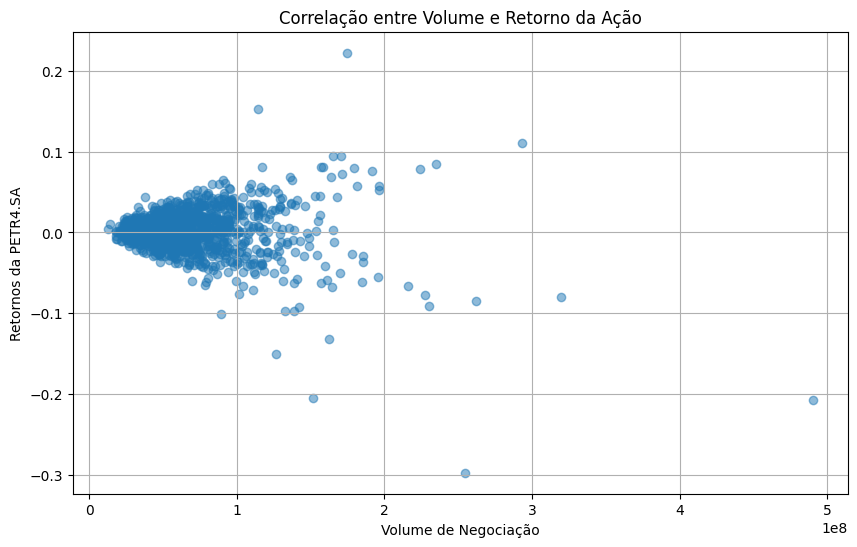

In [77]:
# Gráfico de dispersão entre volume de negociação e retorno da ação
plt.figure(figsize=(10, 6))
plt.scatter(dados_acao_volume, retorno_acao2, alpha=0.5)
plt.title("Correlação entre Volume e Retorno da Ação")
plt.xlabel("Volume de Negociação")
plt.ylabel("Retornos da PETR4.SA")
plt.grid(True)
plt.show()

### Ibovespa

In [78]:
# Define o ticker
ticker_acao = "PETR4.SA"
ticker_ibovespa = "^BVSP"

In [79]:
# Chama biblioteca yf
ibovespa = yf.Ticker(ticker_ibovespa)

In [80]:
# Chama biblioteca yf ação
acao_petr = yf.Ticker(ticker_acao)

In [81]:
# Informa data de inicio e fim
inicio = "2019-04-08"
fim = "2024-04-08"

In [82]:
# Baixa os dados de fechamento ajustado ("Adj Close") e fechamento ("Close") da ação PETR4.SA
dados_acao_adj_close = yf.download(ticker_acao, start=inicio, end=fim)["Adj Close"]
dados_acao_close = yf.download(ticker_acao, start=inicio, end=fim)["Close"]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [83]:
# Baixa todos os dados disponíveis da ação PETR4.SA e do índice Ibovespa no período especificado
dados_acao_petr = yf.download(ticker_acao, start=inicio, end=fim)
dados_ibovespa_close = yf.download(ticker_ibovespa, start=inicio, end=fim)["Close"]
dados_ibovespa = yf.download(ticker_ibovespa, start=inicio, end=fim)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [84]:
# Mostra os dados de fechamento ajustado da ação PETR4.SA
dados_acao_adj_close

Date
2019-04-08    10.365391
2019-04-09    10.333495
2019-04-10    10.198834
2019-04-11     9.922423
2019-04-12     9.153435
                ...    
2024-04-01    35.099995
2024-04-02    36.004295
2024-04-03    35.817841
2024-04-04    35.407642
2024-04-05    35.519516
Name: Adj Close, Length: 1242, dtype: float64

In [85]:
# Mostra os dados de fechamento da ação PETR4.SA
dados_acao_close

Date
2019-04-08    29.250000
2019-04-09    29.160000
2019-04-10    28.780001
2019-04-11    28.000000
2019-04-12    25.830000
                ...    
2024-04-01    37.650002
2024-04-02    38.619999
2024-04-03    38.419998
2024-04-04    37.980000
2024-04-05    38.099998
Name: Close, Length: 1242, dtype: float64

In [86]:
# Exibe todos os dados disponíveis da ação PETR4.SA no período solicitado
dados_acao_petr

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-08,29.059999,29.389999,28.980000,29.250000,10.365391,55270000
2019-04-09,29.030001,29.240000,28.670000,29.160000,10.333495,43863700
2019-04-10,29.549999,29.570000,28.780001,28.780001,10.198834,62005200
2019-04-11,28.700001,28.700001,27.870001,28.000000,9.922423,56126400
2019-04-12,26.469999,26.969999,25.570000,25.830000,9.153435,227307600
...,...,...,...,...,...,...
2024-04-01,37.500000,37.709999,37.209999,37.650002,35.099995,23697800
2024-04-02,37.820000,38.650002,37.770000,38.619999,36.004295,45930700
2024-04-03,38.700001,39.009998,38.220001,38.419998,35.817841,31437200


In [87]:
# Exibe os dados de fechamento do índice Ibovespa
dados_ibovespa_close

Date
2019-04-08     97369.0
2019-04-09     96292.0
2019-04-10     95953.0
2019-04-11     94755.0
2019-04-12     92875.0
                ...   
2024-04-01    126990.0
2024-04-02    127549.0
2024-04-03    127318.0
2024-04-04    127428.0
2024-04-05    126795.0
Name: Close, Length: 1242, dtype: float64

In [88]:
# Exibe todos os dados disponíveis do índice Ibovespa no período solicitado
dados_ibovespa

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-08,97110.0,97610.0,96743.0,97369.0,97369.0,3430800
2019-04-09,97366.0,97366.0,95488.0,96292.0,96292.0,3733400
2019-04-10,96292.0,96902.0,95670.0,95953.0,95953.0,4574600
2019-04-11,95954.0,95954.0,94173.0,94755.0,94755.0,3530500
2019-04-12,94747.0,94768.0,92516.0,92875.0,92875.0,6712200
...,...,...,...,...,...,...
2024-04-01,128106.0,128659.0,126772.0,126990.0,126990.0,9372600
2024-04-02,126990.0,127654.0,126669.0,127549.0,127549.0,9073600
2024-04-03,127546.0,127694.0,126181.0,127318.0,127318.0,11032700


In [89]:
# Gera estatísticas
dados_ibovespa.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1.242000e+03
mean,109721.079710,110727.917874,108722.214976,109742.065217,109742.065217,1.001725e+07
std,11740.198971,11520.438878,11927.983169,11744.295050,11744.295050,3.838896e+06
min,63604.000000,67604.000000,61691.000000,63570.000000,63570.000000,0.000000e+00
25%,102722.500000,103800.750000,101709.000000,102777.500000,102777.500000,7.813625e+06
50%,110336.500000,111549.500000,109401.000000,110399.000000,110399.000000,1.022375e+07
75%,117557.750000,118397.750000,116629.500000,117558.750000,117558.750000,1.237582e+07
max,134194.000000,134392.000000,133832.000000,134194.000000,134194.000000,2.602930e+07


In [90]:
# Transpõe as estatísticas descritivas do DataFrame
dados_ibovespa.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1242.0,1.097211e+05,1.174020e+04,63604.0,102722.50,110336.5,117557.75,134194.0
High,1242.0,1.107279e+05,1.152044e+04,67604.0,103800.75,111549.5,118397.75,134392.0
Low,1242.0,1.087222e+05,1.192798e+04,61691.0,101709.00,109401.0,116629.50,133832.0
Close,1242.0,1.097421e+05,1.174430e+04,63570.0,102777.50,110399.0,117558.75,134194.0
Adj Close,1242.0,1.097421e+05,1.174430e+04,63570.0,102777.50,110399.0,117558.75,134194.0
Volume,1242.0,1.001725e+07,3.838896e+06,0.0,7813625.00,10223750.0,12375825.00,26029300.0


In [91]:
# Fornece informações sobre o DataFrame Ibovespa
dados_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1242 entries, 2019-04-08 to 2024-04-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1242 non-null   float64
 1   High       1242 non-null   float64
 2   Low        1242 non-null   float64
 3   Close      1242 non-null   float64
 4   Adj Close  1242 non-null   float64
 5   Volume     1242 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 67.9 KB


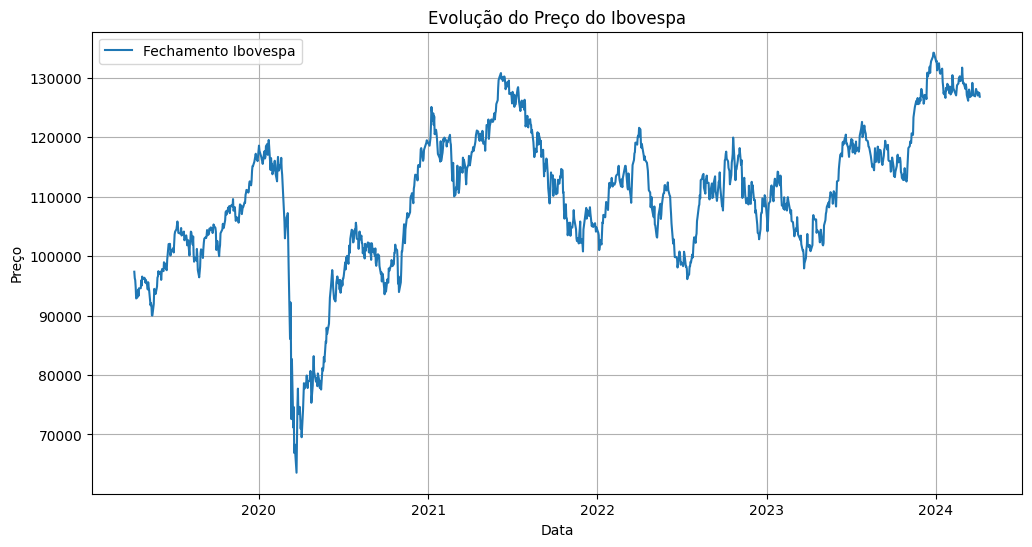

In [92]:
# Gráfico de série temporal evolução do preço
plt.figure(figsize=(12, 6))
plt.plot(dados_ibovespa['Close'], label='Fechamento Ibovespa')
plt.title('Evolução do Preço do Ibovespa')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.legend()
plt.show()

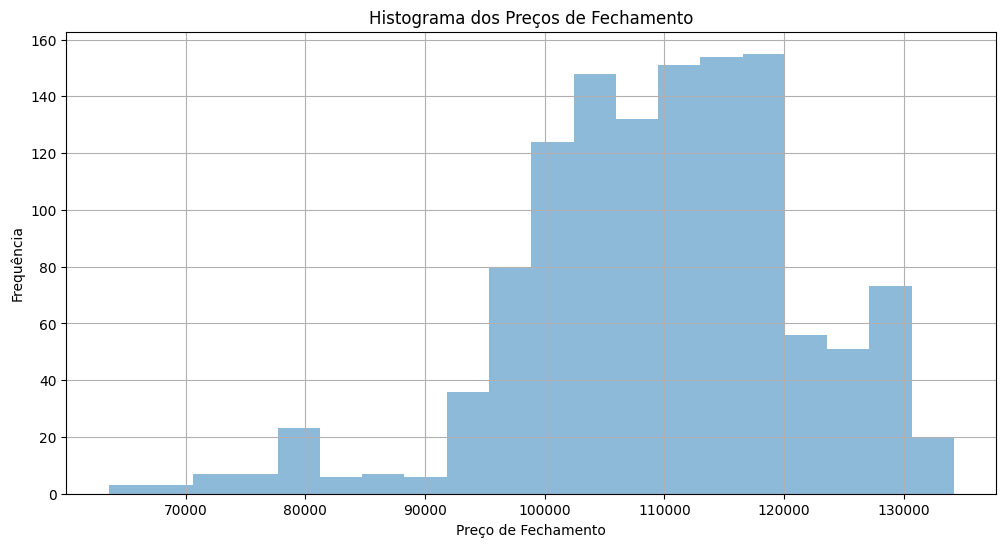

In [93]:
# Histograma com preços de fechamento Ibovespa
dados_ibovespa_close.hist(bins=20, alpha=0.5, figsize=(12, 6))
plt.title('Histograma dos Preços de Fechamento')
plt.xlabel('Preço de Fechamento')
plt.ylabel('Frequência')
plt.show()

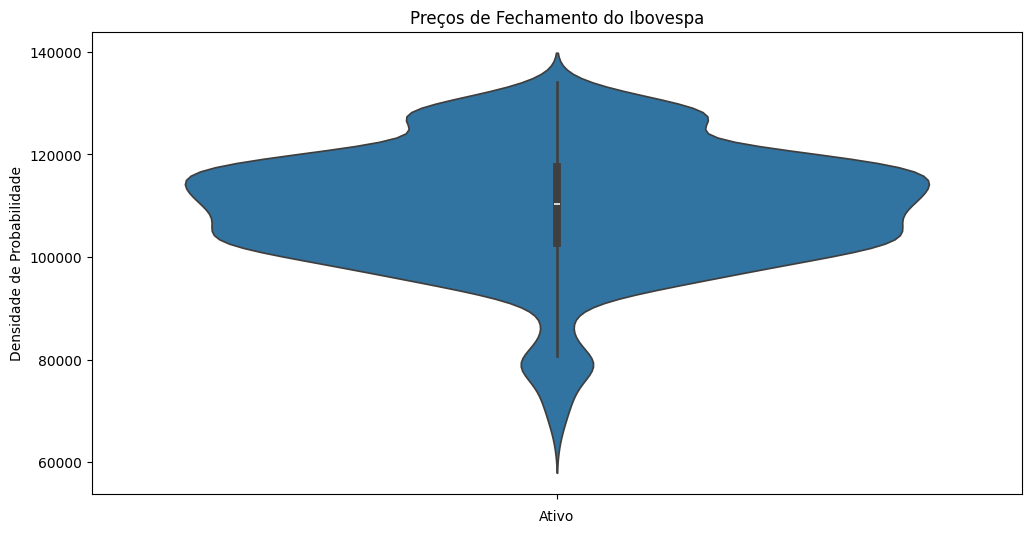

In [94]:
# Violino com probabilidade de densidade
plt.figure(figsize=(12, 6))
sns.violinplot(data=dados_ibovespa_close)
plt.title('Preços de Fechamento do Ibovespa')
plt.xlabel('Ativo')
plt.ylabel('Densidade de Probabilidade')
plt.show()

In [95]:
# Verifica histórico Ibovespa
historico_ibovespa = ibovespa.history(start=inicio, end=fim)
print(historico_ibovespa)

                               Open      High       Low     Close    Volume  \
Date                                                                          
2019-04-08 00:00:00-03:00   97110.0   97610.0   96743.0   97369.0   3430800   
2019-04-09 00:00:00-03:00   97366.0   97366.0   95488.0   96292.0   3733400   
2019-04-10 00:00:00-03:00   96292.0   96902.0   95670.0   95953.0   4574600   
2019-04-11 00:00:00-03:00   95954.0   95954.0   94173.0   94755.0   3530500   
2019-04-12 00:00:00-03:00   94747.0   94768.0   92516.0   92875.0   6712200   
...                             ...       ...       ...       ...       ...   
2024-04-01 00:00:00-03:00  128106.0  128659.0  126772.0  126990.0   9372600   
2024-04-02 00:00:00-03:00  126990.0  127654.0  126669.0  127549.0   9073600   
2024-04-03 00:00:00-03:00  127546.0  127694.0  126181.0  127318.0  11032700   
2024-04-04 00:00:00-03:00  127313.0  129627.0  127178.0  127428.0  13229200   
2024-04-05 00:00:00-03:00  127422.0  127432.0  12639

In [96]:
# Verifica histórico ação PETR4.SA
historico_acao = acao_petr.history(start=inicio, end=fim)
print(historico_acao)

                                Open       High        Low      Close  \
Date                                                                    
2019-04-08 00:00:00-03:00  10.298060  10.415003  10.269710  10.365391   
2019-04-09 00:00:00-03:00  10.287427  10.361845  10.159853  10.333495   
2019-04-10 00:00:00-03:00  10.471701  10.478788  10.198834  10.198834   
2019-04-11 00:00:00-03:00  10.170484  10.170484   9.876355   9.922423   
2019-04-12 00:00:00-03:00   9.380233   9.557419   9.061298   9.153435   
...                              ...        ...        ...        ...   
2024-04-01 00:00:00-03:00  34.960153  35.155929  34.689793  35.099995   
2024-04-02 00:00:00-03:00  35.258479  36.032266  35.211867  36.004295   
2024-04-03 00:00:00-03:00  36.078879  36.367880  35.631389  35.817841   
2024-04-04 00:00:00-03:00  35.864457  36.806048  34.894894  35.407642   
2024-04-05 00:00:00-03:00  35.333065  35.957684  34.652504  35.519516   

                              Volume  Dividends  S

In [97]:
# Calcula retorno percentual diário do preço
retorno_acao = dados_acao_adj_close.pct_change().dropna()
retorno_ibovespa = dados_ibovespa_close.pct_change().dropna()

In [98]:
# Mostra o retorno diário PETR4.SA
retorno_acao

Date
2019-04-09   -0.003077
2019-04-10   -0.013031
2019-04-11   -0.027102
2019-04-12   -0.077500
2019-04-15    0.003871
                ...   
2024-04-01    0.007762
2024-04-02    0.025764
2024-04-03   -0.005179
2024-04-04   -0.011452
2024-04-05    0.003160
Name: Adj Close, Length: 1241, dtype: float64

In [99]:
# Mostra o retorno diário Ibovespa
retorno_ibovespa

Date
2019-04-09   -0.011061
2019-04-10   -0.003521
2019-04-11   -0.012485
2019-04-12   -0.019841
2019-04-15    0.002240
                ...   
2024-04-01   -0.008712
2024-04-02    0.004402
2024-04-03   -0.001811
2024-04-04    0.000864
2024-04-05   -0.004968
Name: Close, Length: 1241, dtype: float64

In [100]:
# Calcula a correlação entre os retornos diários da ação PETR4.SA e os retornos diários do índice Ibovespa
correlacao = retorno_acao.corr(retorno_ibovespa)
correlacao

0.7500349858150254

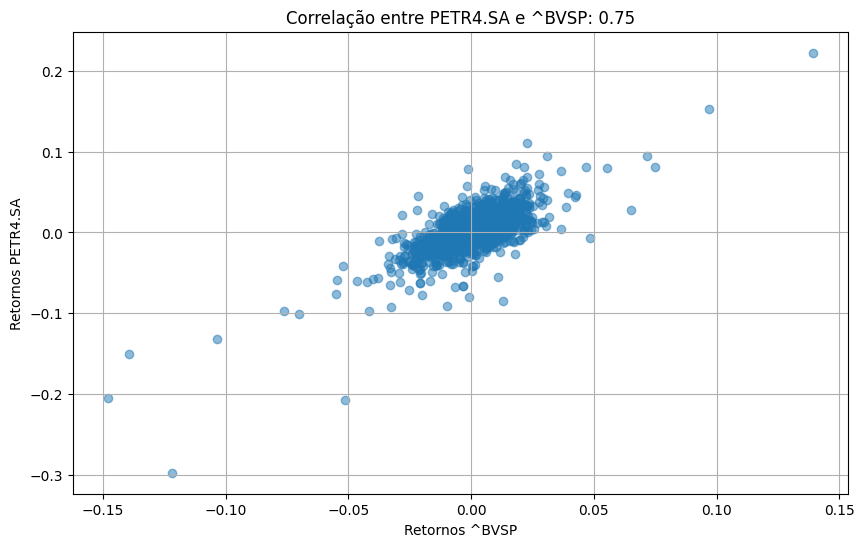

In [101]:
# Gráfico de dispersão com correlação entre PETR4.SA e IBOVESPA
plt.figure(figsize=(10, 6))
plt.scatter(retorno_ibovespa, retorno_acao, alpha=0.5)
plt.title(f"Correlação entre {ticker_acao} e {ticker_ibovespa}: {correlacao:.2f}")
plt.xlabel(f"Retornos {ticker_ibovespa}")
plt.ylabel(f"Retornos {ticker_acao}")
plt.grid(True)
plt.show()

### API do Banco Central para SELIC

In [102]:
# URL da API que fornece os dados da série histórica da taxa SELIC
url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json"

In [103]:
# Dados da série histórica da taxa SELIC
response = requests.get(url)

In [104]:
# Verifica se a requisição foi bem-sucedida (status code 200)
if response.status_code == 200:
    selic_data = pd.DataFrame(response.json())
    selic_data['data'] = pd.to_datetime(selic_data['data'], dayfirst=True)
    selic_data.columns = ['Data', 'SELIC']
    selic_data.set_index('Data', inplace=True)
    print(selic_data.head())
else:
    print("Falha ao obter os dados da SELIC.")

               SELIC
Data                
1986-06-04  0.065041
1986-06-05  0.067397
1986-06-06  0.066740
1986-06-09  0.068247
1986-06-10  0.067041


In [144]:
# Define a data inicial e final 
datainicialbcb = '08/04/2019'
datafinalbcb = data_atual2

In [145]:
# URL com parâmetros para obter os dados da SELIC no periodo 
url2 = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial={datainicialbcb}&dataFinal={datafinalbcb}'

In [146]:
# Obtém os dados da SELIC no intervalo de datas especificado
response = requests.get(url2)

In [147]:
# Verifica se a requisição foi bem-sucedida (status code 200)
if response.status_code == 200:
    selic_data = pd.DataFrame(response.json())
    selic_data['data'] = pd.to_datetime(selic_data['data'], dayfirst=True)
    selic_data.columns = ['Data', 'SELIC']
    selic_data.set_index('Data', inplace=True)
    print(selic_data.head())
else:
    print("Falha ao obter os dados da SELIC.")

               SELIC
Data                
2019-04-08  0.024620
2019-04-09  0.024620
2019-04-10  0.024620
2019-04-11  0.024620
2019-04-12  0.024620


In [148]:
# Exibe informações sobre o DataFrame
selic = selic_data
selic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1290 entries, 2019-04-08 to 2024-05-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SELIC   1290 non-null   object
dtypes: object(1)
memory usage: 20.2+ KB


In [149]:
# Coverte coluna tipo object para float
s = selic_data.select_dtypes(include='object').columns
selic_data[s] = selic_data[s].astype("float")
selic_data

,SELIC
Data,
2019-04-08,0.02462
2019-04-09,0.02462
2019-04-10,0.02462
2019-04-11,0.02462
2019-04-12,0.02462
...,...
2024-05-21,0.03927
2024-05-22,0.03927
2024-05-23,0.03927


In [150]:
# Verifica coluna convertida
selic_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1290 entries, 2019-04-08 to 2024-05-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SELIC   1290 non-null   float64
dtypes: float64(1)
memory usage: 20.2 KB


In [151]:
# Converte colunas tipo object para float
s = selic.select_dtypes(include='object').columns
selic[s] = selic[s].astype("float")
selic

,SELIC
Data,
2019-04-08,0.02462
2019-04-09,0.02462
2019-04-10,0.02462
2019-04-11,0.02462
2019-04-12,0.02462
...,...
2024-05-21,0.03927
2024-05-22,0.03927
2024-05-23,0.03927


In [152]:
# Verifica novamente coluna
selic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1290 entries, 2019-04-08 to 2024-05-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SELIC   1290 non-null   float64
dtypes: float64(1)
memory usage: 20.2 KB


In [153]:
# Ajusta os valores da coluna 'SELIC' para taxa em formato percentual
selic_data['SELIC'] = selic_data['SELIC'] * 100

In [154]:
# Verifica DataFrame com os ajuste da coluna SELIC
selic_data

,SELIC
Data,
2019-04-08,2.462
2019-04-09,2.462
2019-04-10,2.462
2019-04-11,2.462
2019-04-12,2.462
...,...
2024-05-21,3.927
2024-05-22,3.927
2024-05-23,3.927


In [155]:
# Verifica a coluna 'SELIC'
selic['SELIC']

Data
2019-04-08    2.462
2019-04-09    2.462
2019-04-10    2.462
2019-04-11    2.462
2019-04-12    2.462
              ...  
2024-05-21    3.927
2024-05-22    3.927
2024-05-23    3.927
2024-05-24    3.927
2024-05-27    3.927
Name: SELIC, Length: 1290, dtype: float64

In [156]:
# Verifica a coluna 'SELIC' do selic_data
selic_data['SELIC']

Data
2019-04-08    2.462
2019-04-09    2.462
2019-04-10    2.462
2019-04-11    2.462
2019-04-12    2.462
              ...  
2024-05-21    3.927
2024-05-22    3.927
2024-05-23    3.927
2024-05-24    3.927
2024-05-27    3.927
Name: SELIC, Length: 1290, dtype: float64

In [157]:
# Obtém o último valor da SELIC
ultimo_valor_selic = selic_data['SELIC'].iloc[-1]
print("SELIC hoje:", ultimo_valor_selic)

SELIC hoje: 3.927


In [158]:
# Verifica os dados
dados_acao

,Open,High,Low,Close,Adj Close,Volume,MM60,MM180
Date,,,,,,,,
2019-04-08,29.059999,29.389999,28.980000,29.250000,10.365389,55270000,NaN,NaN
2019-04-09,29.030001,29.240000,28.670000,29.160000,10.333495,43863700,NaN,NaN
2019-04-10,29.549999,29.570000,28.780001,28.780001,10.198833,62005200,NaN,NaN
2019-04-11,28.700001,28.700001,27.870001,28.000000,9.922425,56126400,NaN,NaN
2019-04-12,26.469999,26.969999,25.570000,25.830000,9.153437,227307600,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-05-20,36.730000,37.240002,36.630001,36.750000,36.750000,40400400,4.996364e+07,4.520424e+07
2024-05-21,36.790001,37.090000,36.570000,36.680000,36.680000,27967400,4.969769e+07,4.522097e+07
2024-05-22,36.500000,37.459999,36.410000,37.180000,37.180000,36528800,4.987508e+07,4.519831e+07


In [159]:
# Informações sobre a coluna 'Close'
dados_acao['Close'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1276 entries, 2019-04-08 to 2024-05-24
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1276 non-null   float64
dtypes: float64(1)
memory usage: 52.2 KB


In [160]:
# Acessa a coluna 'Close'
dados_acao['Close']

Date
2019-04-08    29.250000
2019-04-09    29.160000
2019-04-10    28.780001
2019-04-11    28.000000
2019-04-12    25.830000
                ...    
2024-05-20    36.750000
2024-05-21    36.680000
2024-05-22    37.180000
2024-05-23    36.810001
2024-05-24    36.610001
Name: Close, Length: 1276, dtype: float64

In [161]:
# Acessa a coluna 'Adj Close'
dados_acao['Adj Close']

Date
2019-04-08    10.365389
2019-04-09    10.333495
2019-04-10    10.198833
2019-04-11     9.922425
2019-04-12     9.153437
                ...    
2024-05-20    36.750000
2024-05-21    36.680000
2024-05-22    37.180000
2024-05-23    36.810001
2024-05-24    36.610001
Name: Adj Close, Length: 1276, dtype: float64

In [162]:
# Concatena os dados de fechamento da ação PETR4.SA e da SELIC filtrada
concatenar_dados = pd.concat([dados_acao['Close'], selic_data], axis=1)
concatenar_dados.columns = ['Petr4.SA Close', 'Selic Rate']

In [163]:
# Exibe os dados concatenados
concatenar_dados

,Petr4.SA Close,Selic Rate
2019-04-08,29.250000,2.4620
2019-04-09,29.160000,2.4620
2019-04-10,28.780001,2.4620
2019-04-11,28.000000,2.4620
2019-04-12,25.830000,2.4620
...,...,...
2021-12-24,NaN,3.4749
2021-12-31,NaN,3.4749
2022-12-30,NaN,5.0788
2023-12-29,NaN,4.3739


In [164]:
# Filtra os valores NaN (ausentes) no DataFrame concatenar_dados
valores_nan = concatenar_dados[concatenar_dados['Petr4.SA Close'].isna()]
valores_nan

,Petr4.SA Close,Selic Rate
2019-07-09,NaN,2.4620
2019-11-20,NaN,1.8985
2019-12-24,NaN,1.7089
2019-12-31,NaN,1.7089
2020-11-20,NaN,0.7469
2020-12-24,NaN,0.7469
2020-12-31,NaN,0.7469
2021-01-25,NaN,0.7469
2021-07-09,NaN,1.6137
2021-12-24,NaN,3.4749


In [165]:
# Mostra quantidade de valores Nan
valores_nan.shape

(14, 2)

In [167]:
# Filtra os valores NaN na coluna 'Close' do dados_acao
valores_nan_acao = dados_acao[dados_acao['Close'].isna()]
valores_nan_acao

,Open,High,Low,Close,Adj Close,Volume,MM60,MM180
Date,,,,,,,,


In [168]:
# Filtra os valores NaN na coluna 'SELIC' do selic_data
valores_nan_selic = selic_data[selic_data['SELIC'].isna()]
valores_nan_selic

,SELIC
Data,


In [169]:
# Remove os valores NaN do concatenar_dados
concatenar_dados_limpos = concatenar_dados.dropna(subset=['Petr4.SA Close'])
concatenar_dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1276 entries, 2019-04-08 to 2024-05-24
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Petr4.SA Close  1276 non-null   float64
 1   Selic Rate      1276 non-null   float64
dtypes: float64(2)
memory usage: 29.9 KB


In [170]:
# Exibe o DataFrame com os dados limpos
concatenar_dados_limpos

,Petr4.SA Close,Selic Rate
2019-04-08,29.250000,2.462
2019-04-09,29.160000,2.462
2019-04-10,28.780001,2.462
2019-04-11,28.000000,2.462
2019-04-12,25.830000,2.462
...,...,...
2024-05-20,36.750000,3.927
2024-05-21,36.680000,3.927
2024-05-22,37.180000,3.927
2024-05-23,36.810001,3.927


In [171]:
# Concatena os dados de fechamento ajustado da ação PETR4.SA e da SELIC filtrada
concatenar_dados2 = pd.concat([dados_acao['Adj Close'], selic_data], axis=1)
concatenar_dados2.columns = ['PETR4.SA Adj Close', 'Selic Rate']

In [172]:
# Exibe o DataFrame com os dados limpos
concatenar_dados2

,PETR4.SA Adj Close,Selic Rate
2019-04-08,10.365389,2.4620
2019-04-09,10.333495,2.4620
2019-04-10,10.198833,2.4620
2019-04-11,9.922425,2.4620
2019-04-12,9.153437,2.4620
...,...,...
2021-12-24,NaN,3.4749
2021-12-31,NaN,3.4749
2022-12-30,NaN,5.0788
2023-12-29,NaN,4.3739


In [173]:
# Remove os valores NaN do DataFrame concatenar_dados2
concatenar_dados_limpos2 = concatenar_dados2.dropna(subset=['PETR4.SA Adj Close'])
concatenar_dados_limpos2

,PETR4.SA Adj Close,Selic Rate
2019-04-08,10.365389,2.462
2019-04-09,10.333495,2.462
2019-04-10,10.198833,2.462
2019-04-11,9.922425,2.462
2019-04-12,9.153437,2.462
...,...,...
2024-05-20,36.750000,3.927
2024-05-21,36.680000,3.927
2024-05-22,37.180000,3.927
2024-05-23,36.810001,3.927


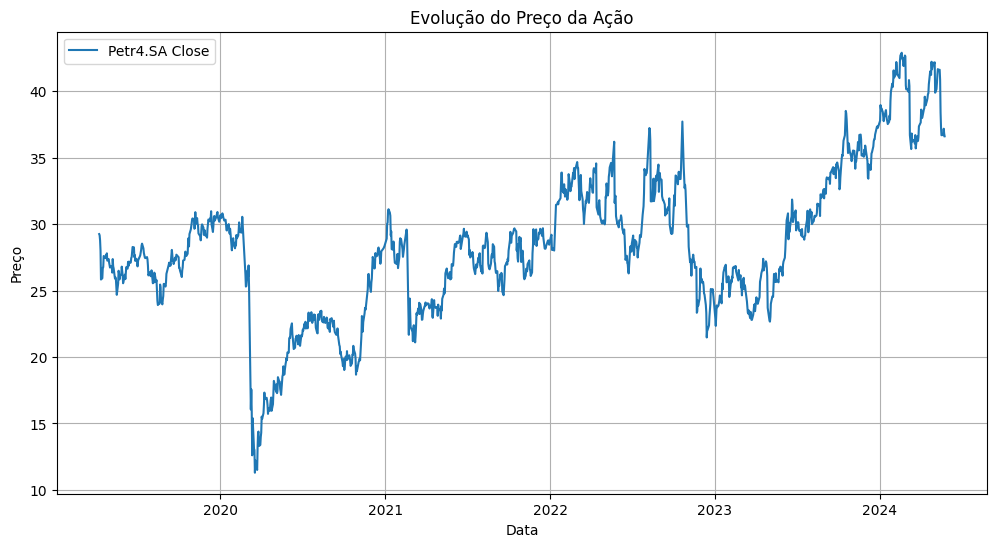

In [174]:
# Série temporal com evolução do preço da ação
plt.figure(figsize=(12, 6))
plt.plot(dados_acao['Close'], label='Petr4.SA Close')
plt.title('Evolução do Preço da Ação')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.legend()
plt.show()

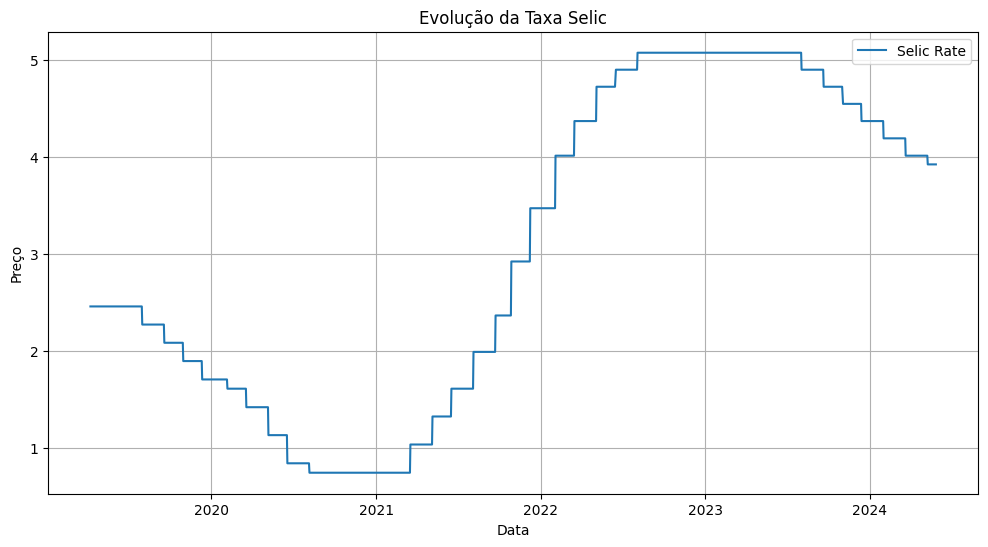

In [176]:
# Preço Selic ao longo dos anos
plt.figure(figsize=(12, 6))
plt.plot(selic_data['SELIC'], label='Selic Rate')
plt.title('Evolução da Taxa Selic')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.legend()
plt.show()

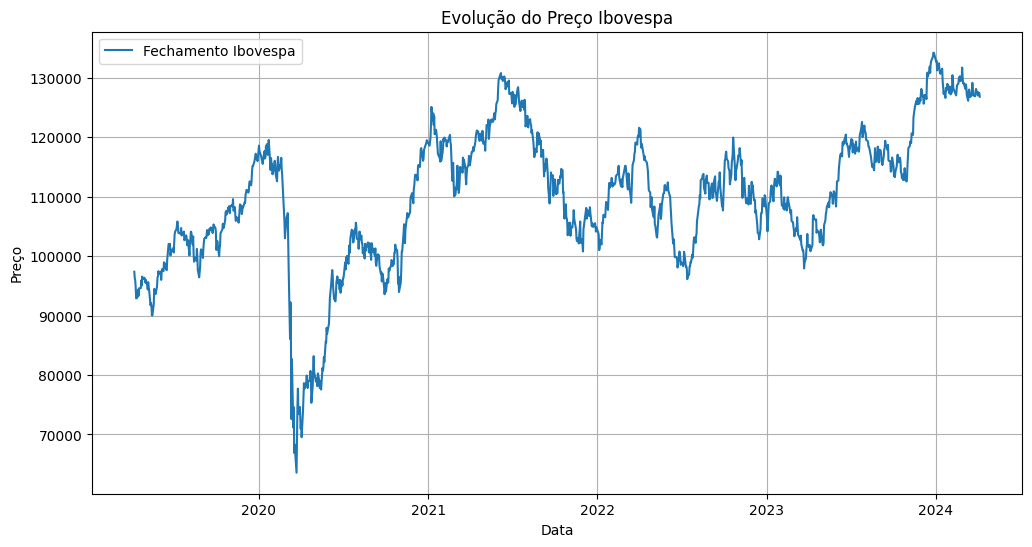

In [177]:
# Preço Ibovespa ao longo dos anos
plt.figure(figsize=(12, 6))
plt.plot(dados_ibovespa['Close'], label='Fechamento Ibovespa')
plt.title('Evolução do Preço Ibovespa')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.legend()
plt.show()

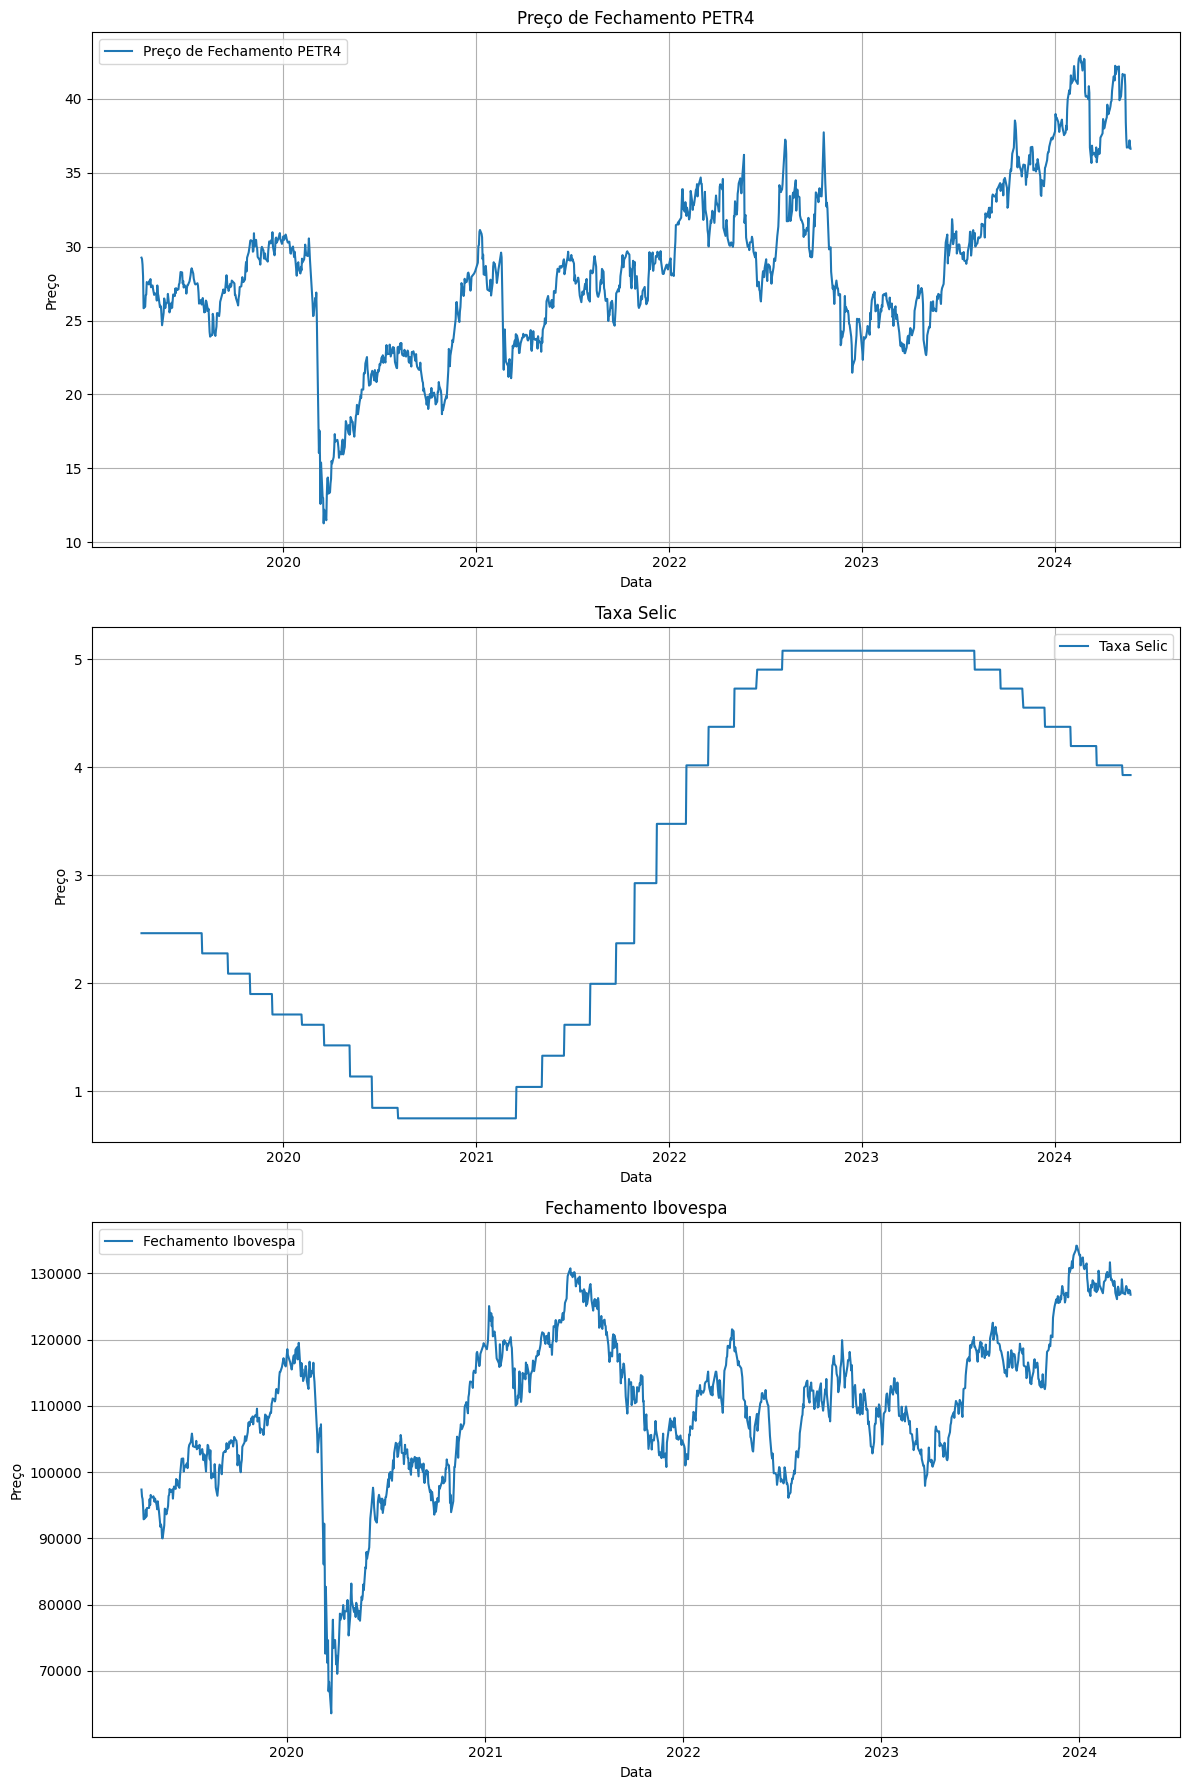

In [178]:
# Série temporal com fechamento PETR4, Taxa Selic e fechamento Ibovespa
fig, axs = plt.subplots(3, 1, figsize=(12, 18))
axs[0].plot(concatenar_dados_limpos['Petr4.SA Close'], label='Preço de Fechamento PETR4')
axs[0].set_title('Preço de Fechamento PETR4')

axs[1].plot(concatenar_dados_limpos['Selic Rate'], label='Taxa Selic')
axs[1].set_title('Taxa Selic')

axs[2].plot(dados_ibovespa['Close'], label='Fechamento Ibovespa')
axs[2].set_title('Fechamento Ibovespa')

for ax in axs:
    ax.set_xlabel('Data')
    ax.set_ylabel('Preço')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

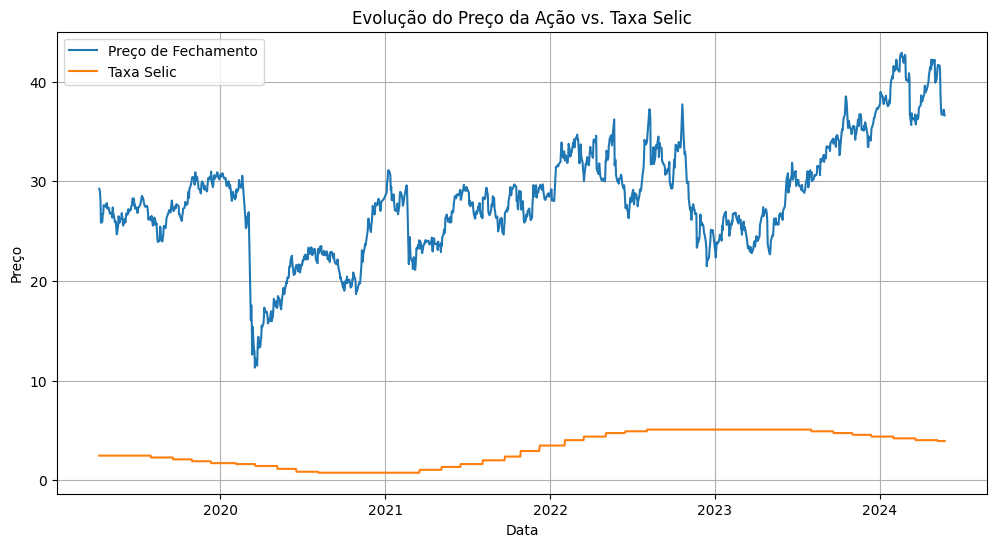

In [179]:
# Série temporal com evoluação preção ação comparado a Taxa Selic
plt.figure(figsize=(12, 6))
plt.plot(concatenar_dados_limpos['Petr4.SA Close'], label='Preço de Fechamento')
plt.plot(concatenar_dados_limpos['Selic Rate'], label='Taxa Selic')
plt.title('Evolução do Preço da Ação vs. Taxa Selic')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.legend()
plt.show()

In [180]:
# Seleciona a coluna 'PETR4.SA Adj Close'
dados_acao_limpos = concatenar_dados_limpos2['PETR4.SA Adj Close']
dados_acao_limpos

2019-04-08    10.365389
2019-04-09    10.333495
2019-04-10    10.198833
2019-04-11     9.922425
2019-04-12     9.153437
                ...    
2024-05-20    36.750000
2024-05-21    36.680000
2024-05-22    37.180000
2024-05-23    36.810001
2024-05-24    36.610001
Name: PETR4.SA Adj Close, Length: 1276, dtype: float64

In [181]:
# Seleciona a coluna 'Selic Rate
dados_selic_limpos = concatenar_dados_limpos['Selic Rate']
dados_selic_limpos

2019-04-08    2.462
2019-04-09    2.462
2019-04-10    2.462
2019-04-11    2.462
2019-04-12    2.462
              ...  
2024-05-20    3.927
2024-05-21    3.927
2024-05-22    3.927
2024-05-23    3.927
2024-05-24    3.927
Name: Selic Rate, Length: 1276, dtype: float64

In [182]:
# Calcula os retornos percentuais diários da ação PETR4.SA e SELIC
retorno_acao_petr = dados_acao_limpos.pct_change().dropna()
retorno_selic = dados_selic_limpos.pct_change().dropna()

In [183]:
# Exibe os retornos percentuais diários
retorno_acao_petr

2019-04-09   -0.003077
2019-04-10   -0.013032
2019-04-11   -0.027102
2019-04-12   -0.077500
2019-04-15    0.003871
                ...   
2024-05-20    0.001635
2024-05-21   -0.001905
2024-05-22    0.013631
2024-05-23   -0.009952
2024-05-24   -0.005433
Name: PETR4.SA Adj Close, Length: 1275, dtype: float64

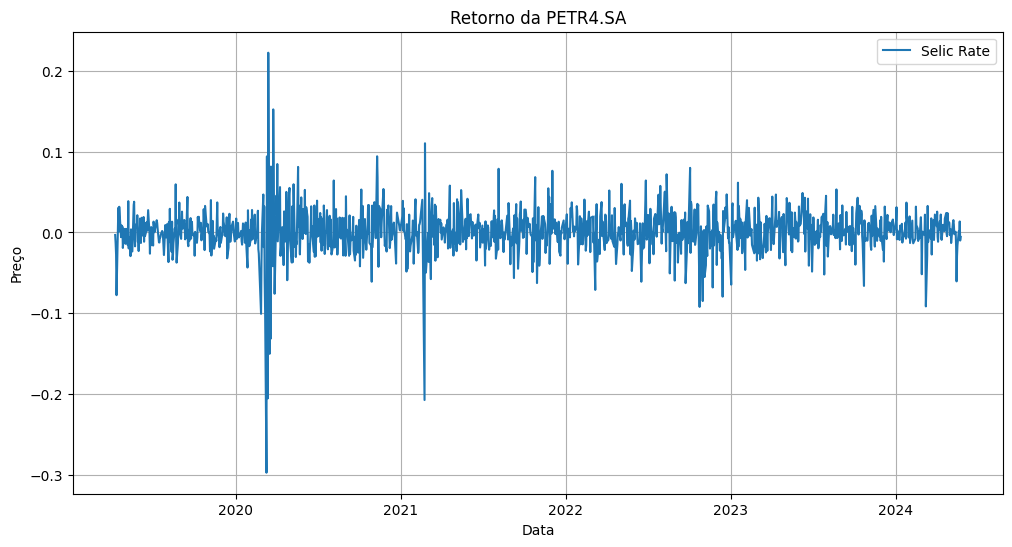

In [184]:
# Série temporal com retorno PETR4.SA 
plt.figure(figsize=(12, 6))
plt.plot(retorno_acao_petr, label='Selic Rate')
plt.title('Retorno da PETR4.SA')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.legend()
plt.show()

In [185]:
# Exibe os retornos percentuais
retorno_selic

2019-04-09    0.0
2019-04-10    0.0
2019-04-11    0.0
2019-04-12    0.0
2019-04-15    0.0
             ... 
2024-05-20    0.0
2024-05-21    0.0
2024-05-22    0.0
2024-05-23    0.0
2024-05-24    0.0
Name: Selic Rate, Length: 1275, dtype: float64

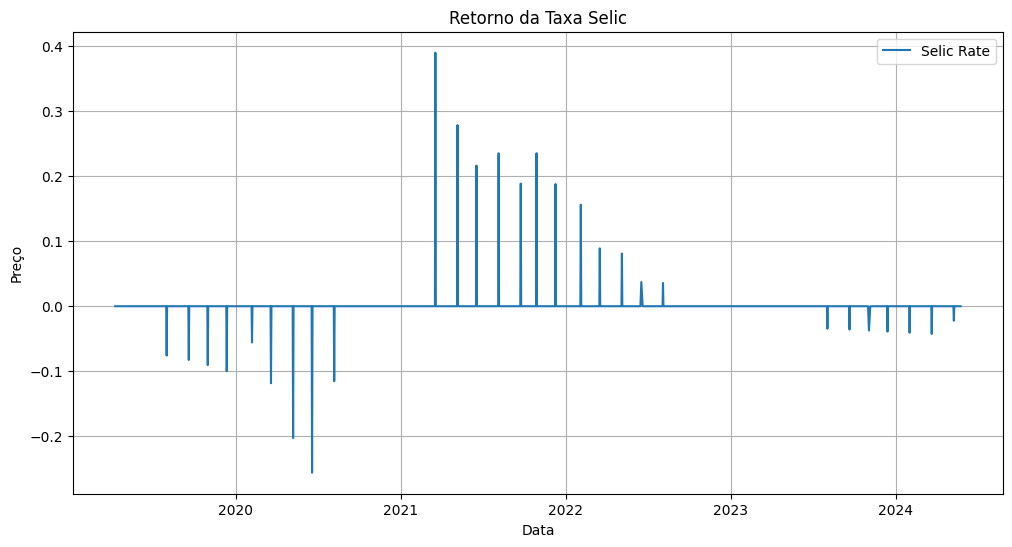

In [186]:
# Plota os retornos da taxa SELIC no gráfico
plt.figure(figsize=(12, 6))
plt.plot(retorno_selic, label='Selic Rate')
plt.title('Retorno da Taxa Selic')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.legend()
plt.show()

In [187]:
#Calcula a correlação entre os retornos da ação PETR4.SA e da taxa SELIC
correlacao_acao_selic = retorno_acao_petr.corr(retorno_selic)
correlacao_acao_selic

-0.030020832812437736

Ausência de correlação entre as variáveis. Confirmação de que a Selic tem influência direta em investimentos de renda fixa e indireta na renda variável.

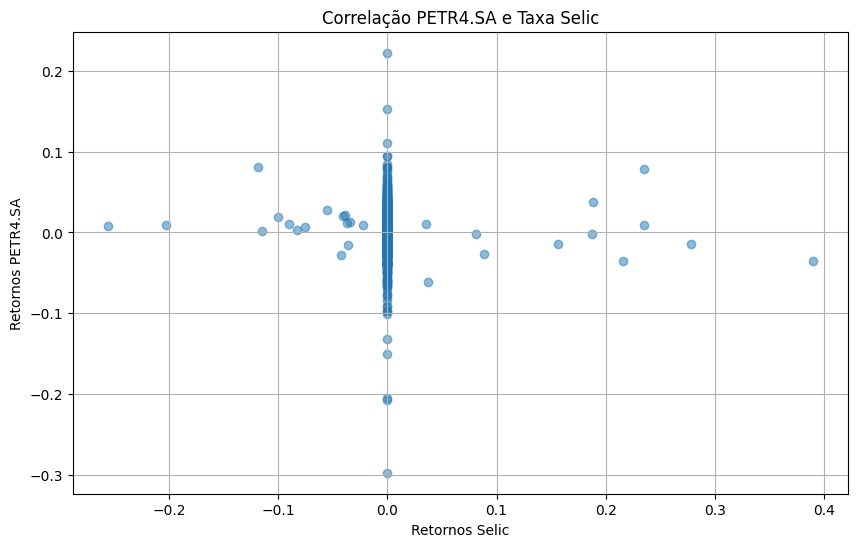

In [188]:
# Gráfico de dispersão para visualizar a correlação entre os retornos da ação PETR4.SA e da taxa SELIC
plt.figure(figsize=(10, 6))
plt.scatter(retorno_selic, retorno_acao_petr, alpha=0.5)
plt.title(f"Correlação PETR4.SA e Taxa Selic")
plt.xlabel(f"Retornos Selic")
plt.ylabel(f"Retornos PETR4.SA")
plt.grid(True)
plt.show()

In [189]:
# Define a data inicial e final para calcular o número de dias úteis
start_date = pd.to_datetime('2024-01-11')
end_date = pd.to_datetime('2024-4-30')

# Calcula o número de dias úteis entre as datas inicial e final
dias_uteis = pd.bdate_range(start_date, end_date).shape[0]

# Exibe o número de dias úteis entre as datas inicial e final
print(f"Número de dias úteis entre {start_date.date()} e {end_date.date()}: {dias_uteis}")

Número de dias úteis entre 2024-01-11 e 2024-04-30: 79


### Regressão logística

Executar bibliotecas do início antes de começar

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [18]:
# Definindo ação e data de pesquisa
data_atual = datetime.datetime.now().strftime('%Y-%m-%d')
ticker = 'PETR4.SA'
inicio = '2019-6-3'
fim = data_atual

In [19]:
# Baixando dados
dados = yf.download(ticker, start=inicio, end=fim)

[*********************100%%**********************]  1 of 1 completed


- É importante calcular o retorno diário da ação para normalizar os dados, pois há muita variação no preço de fechamento.
- O 'Adj Close' é utilizado pois representa o preço de fechamento ajustado, ou seja, representa o preço engloba todos os elementos que influenciam o preço da ação, como: pagamento de dividendos e splits.

In [20]:
# Calculando o retorno diário da ação e normalizar o dados com a coluna Alvo para o modelo de aprendizagem
dados['Retorno'] = dados['Adj Close'].pct_change()
dados['Alvo'] = np.where(dados['Retorno'] > 0, 1, 0)
dados.dropna(inplace=True)
dados

,Open,High,Low,Close,Adj Close,Volume,Retorno,Alvo
Date,,,,,,,,
2019-06-04,26.290001,26.370001,26.030001,26.200001,9.326276,37331100,0.008080,1
2019-06-05,26.180000,26.290001,25.559999,25.860001,9.205247,65282100,-0.012977,0
2019-06-06,26.170000,26.629999,25.719999,26.280001,9.354753,87836900,0.016241,1
2019-06-07,26.690001,26.830000,26.370001,26.760000,9.525616,52235500,0.018265,1
2019-06-10,26.600000,26.889999,26.520000,26.650000,9.486460,39666800,-0.004111,0
...,...,...,...,...,...,...,...,...
2024-05-24,37.070000,37.189999,36.570000,36.610001,36.610001,23684700,-0.005433,0
2024-05-27,36.720001,37.080002,36.689999,37.009998,37.009998,13623300,0.010926,1
2024-05-28,37.439999,38.290001,37.410000,37.799999,37.799999,46437700,0.021346,1


In [21]:
# Preparação de dados
X = dados[['Open', 'High', 'Low', 'Volume']]
y = dados['Alvo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Padronização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Treinamento do modelo
modelo = LogisticRegression()
modelo.fit(X_train_scaled, y_train)

LogisticRegression()

In [24]:
# Previsões
previsoes = modelo.predict(X_test_scaled)

In [25]:
# Avaliação do modelo
acuracia = accuracy_score(y_test, previsoes)
print('Acurácia:', acuracia)

Acurácia: 0.7068273092369478


In [26]:
# Realizando a previsão para o último dia dos dados
ultimo_dia = X_test_scaled[-1].reshape(1, -1)
previsao_ultimo_dia = modelo.predict(ultimo_dia)[0]

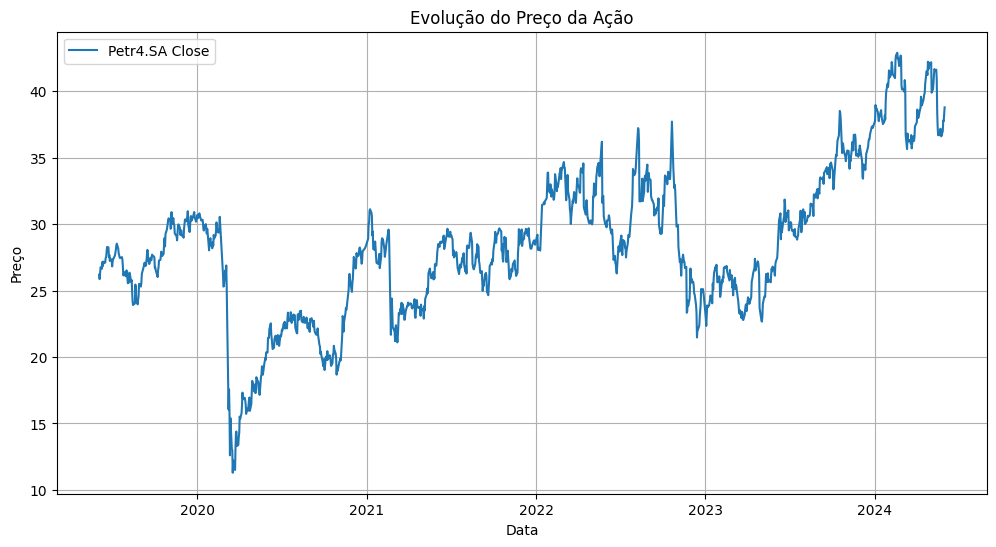

Fechamento do último dia: 38.790000915527344


In [27]:
# Série temporal com evolução do preço da ação
plt.figure(figsize=(12, 6))
plt.plot(dados['Close'], label='Petr4.SA Close')
plt.title('Evolução do Preço da Ação')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.legend()
plt.show()

print(f'Fechamento do último dia:', dados['Close'].iloc[-1])

In [28]:
# Imprimindo a recomendação
if previsao_ultimo_dia == 1:
    print('Recomendação: Comprar')
else:
    print('Recomendação: Vender')

Recomendação: Comprar


### Random Forest

Executar bibliotecas do início antes de começar

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [7]:
# Definindo ação e data de pesquisa
data_atual = datetime.datetime.now().strftime('%Y-%m-%d')
ticker = 'PETR4.SA'
inicio = '2019-4-8'
fim = data_atual

In [8]:
# Baixando dados
dados = yf.download(ticker, start=inicio, end=fim)

[*********************100%%**********************]  1 of 1 completed


In [9]:
# Engenharia de recursos
dados['Retorno'] = dados['Adj Close'].pct_change()
dados['Alvo'] = np.where(dados['Retorno'] > 0, 1, 0) 
dados.dropna(inplace=True)

In [10]:
# Preparação de dados
X = dados[['Open', 'High', 'Low', 'Volume']]
y = dados['Alvo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Padronização dos recursos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Treinamento do modelo com parâmetros básicos
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [36]:
# Previsões
previsoes = modelo.predict(X_test_scaled)

In [37]:
# Avaliação do modelo
acuracia = accuracy_score(y_test, previsoes)
print('Acurácia:', acuracia)

Acurácia: 0.6144578313253012


In [38]:
# Outra opção de treinamento do modelo com Hiperparâmetros adicionais
modelo = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)
modelo.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [41]:
# Previsões
previsoes = modelo.predict(X_test_scaled)

In [40]:
# Avaliação do modelo
acuracia = accuracy_score(y_test, previsoes)
print('Acurácia:', acuracia)

Acurácia: 0.642570281124498


In [32]:
# Realizando a previsão para o último dia dos dados
ultimo_dia = X_test_scaled[-1].reshape(1, -1)
previsao_ultimo_dia = modelo.predict(ultimo_dia)[0]

In [33]:
# Imprimindo a recomendação
if previsao_ultimo_dia == 1:
    print('Recomendação: Comprar')
else:
    print('Recomendação: Vender')

Recomendação: Comprar
